<div class="alert alert-block alert-warning"> This notebook is still a work in progress </div>

<div class="alert alert-block alert-warning"> For final publication, rename this notebook to be 9_molecule_grid_figure </div>

# Notebook for creating molecule grid figure

This notebook is still a work in progress and details should be clarified

Notebook relied on nglview for visualisation of molecules. A new colour scheme has been defined to make the molecules look nice. The view is initalised with the Mpro protein target. All selected molecules are read by RDKit, then read into nglview. Additionally, all reference fragments are also read by RDKit and nglview. Every molecule is sequentially added to nglview, and the component number representing that molecule is stored in a dataframe. This means each molecule can be easily indexed to show and hide. 

Proper documentation of this is still needed.

In [1]:
#molecules selected for visualisation

['mol_2023_03_01_1521512_000',
 'mol_2023_02_08_1413112_000',
 'mol_2023_03_01_1144532_000',
 'mol_2023_02_08_1040511_000',
 'mol_2023_02_24_0204060_000',
 'mol_2023_02_09_1352421_000',
 'mol_2023_02_09_1541580_000',
 'mol_2023_02_08_0217380_000']

['mol_2023_03_01_1521512_000',
 'mol_2023_02_08_1413112_000',
 'mol_2023_03_01_1144532_000',
 'mol_2023_02_08_1040511_000',
 'mol_2023_02_24_0204060_000',
 'mol_2023_02_09_1352421_000',
 'mol_2023_02_09_1541580_000',
 'mol_2023_02_08_0217380_000']

In [2]:
import nglview as nv
from PIL import Image
import pandas as pd

In [3]:
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from openbabel import pybel
from rdkit import Chem


def rdkit_fix_radicals(mol,add_h=False,flatten=False,uncharge=True):
    """
    Atoms with unfilled valance get radicals assigned.
    Openbabel will have assigned bond orders based on bond length.
    Here I assume all radical electrons should instead be hydrogen atoms
    """
    for atom in mol.GetAtoms():
        radicals = atom.GetNumRadicalElectrons()
        atom.SetNumRadicalElectrons(0)
        atom.SetNumExplicitHs(atom.GetNumExplicitHs() + radicals)

    if flatten:
        mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))

    if add_h:
        mol = Chem.AddHs(mol,addCoords=True)

    if uncharge:
        un = rdMolStandardize.Uncharger()
        mol = un.uncharge(mol)

    return mol


def xyz_to_mol_clean(xyz, add_h=True, flatten=False):
    """
    add_h - add RDKit hydrogens
    flatten - run Chem.MolFromSmiles(Chem.MolToSmiles(x)) such that geometry infromation is lost
    
    Sometimes these imports fail
    In these cases this function returns False
    """
    try:
        mol_pybel = pybel.readstring("xyz", xyz)
        mol_mol2 = mol_pybel.write("mol2")

        #RDKit - clean radicals
        mol_rdkit = Chem.MolFromMol2Block(mol_mol2)
        mol_final = rdkit_fix_radicals(mol_rdkit, add_h=add_h, flatten=flatten)

        return mol_final
    
    except:
        return False
    
    
def get_fragment_path(fragment_name):
    fragment_path = f"mpro_ligands/Mpro-{fragment_name}_0A.xyz"
    return fragment_path

In [4]:
def get_mols_from_df(df, index):
    fragment_mols = []
    for i, fragment_name in enumerate(df.iloc[index]["reference_fragments"]):#was 1

        fragment_path = get_fragment_path(fragment_name)
        with open(fragment_path, "r") as readfile:
            fragment_xyz = readfile.read()
        fragment_mol = xyz_to_mol_clean(fragment_xyz)
        fragment_mols.append(fragment_mol)


    experiments_path = "experiments/"
    sample_path = experiments_path+df.iloc[index]["exp_id"]+"/"+df.iloc[index]["mol_id"]+".txt"
    with open(sample_path, "r") as readfile:
        sample_xyz = readfile.read()
    sample_mol = xyz_to_mol_clean(sample_xyz)
    
    return sample_mol, fragment_mols

In [5]:
import matplotlib.cm as color_map
from matplotlib import colors
import numpy as np
from nglview.color import ColormakerRegistry


def create_new_scheme(name, color_mapping):
    """
    I do not understand this code!
    """
    
    cm = ColormakerRegistry
    cm.add_scheme_func(name,f'''
     this.atomColor = function (atom) {{
         if (atom.element == "C") {{
           return {color_mapping["C"]} // C
         }} else if (atom.element == "H") {{
           return {color_mapping["H"]}
         }} else if (atom.element == "N") {{
           return {color_mapping["N"]}
         }} else if (atom.element == "O") {{
           return {color_mapping["O"]}
         }} else if (atom.element == "S") {{
           return {color_mapping["S"]}
            }} else if (atom.element == "BR") {{
           return {color_mapping["BR"]}
            }} else if (atom.element == "CL") {{
           return {color_mapping["CL"]}
            }} else if (atom.element == "P") {{
           return {color_mapping["P"]}
            }} else if (atom.element == "B") {{
           return {color_mapping["B"]}
           }} else if (atom.element == "F") {{
           return {color_mapping["F"]}
         }}
     }}
    ''')
    
    return

#The original colour map
"""
atom_cm = {
    'C': 0x909090,
    'H': 0xFFFFFF,
    'N': 0x3050F8,
    'O': 0xFF0D0D,
    'S': 0xFFFF30,
    'BR': 0xA62929,
    'CL': 0x1FF01F,
    'P': 0xFF8000,
    'B': 0xFFB5B5,
    'F': 0x90E050,
}
"""

#Modified colour map for SILVR paper
atom_cm = {
    'C': 0x909090,
    'H': 0xFFFFFF,
    'N': 0x385CFF,#modified
    'O': 0xD82033,#modified
    'S': 0xFFFF30,
    'BR': 0xA62929,
    'CL': 0x1FF01F,
    'P': 0xFF8000,
    'B': 0xFFB5B5,
    'F': 0x90E050,
}

palette = color_map.Set3(np.linspace(0, 1, 7))

mol_cms = []

for i,p in enumerate(palette):
    atom_cm["C"] = "0x"+colors.rgb2hex(p)[1:]
    print("Adding: ", atom_cm["C"])
    create_new_scheme(f"mol_cm_{i}", atom_cm)
    
    mol_cms.append(f"mol_cm_{i}")
    
mol_cms = mol_cms*10

Adding:  0x8dd3c7
Adding:  0xbebada
Adding:  0x80b1d3
Adding:  0xb3de69
Adding:  0xd9d9d9
Adding:  0xccebc5
Adding:  0xffed6f


In [6]:
def get_mol_from_name(mol_name, df):
    """
    Sorry this is quite hacky
    """
    if mol_name[0]=="x":
        #mpro fragment
        mol_path = f"mpro_ligands/Mpro-{mol_name}_0A.xyz"
        with open(mol_path, "r") as readfile:
            mol_xyz = readfile.read()
        mol = xyz_to_mol_clean(mol_xyz)
    
    elif mol_name[0]=="m":
        #sample
        experiments_path = "experiments/"
        exp_id = str(df[df["mol_id"]==mol_name]["exp_id"].iloc[0])
        mol_path = experiments_path+exp_id+"/"+mol_name+".txt"
    
        with open(mol_path, "r") as readfile:
            mol_xyz = readfile.read()
        mol = xyz_to_mol_clean(mol_xyz)
        
    else:
        raise Exception("Can not read molecule ", name)
        
    return mol


def get_mol_from_path(mol_path):
    """
    Sorry this is quite hacky
    """
    with open(mol_path, "r") as readfile:
        mol_xyz = readfile.read()
    mol = xyz_to_mol_clean(mol_xyz)

        
    return mol

In [7]:
def show_silvr_rates_evolution(silvr_rates_molecules, component_map,factor=2):
    hide_everything()
    
    all_figures = []
    
    for i, row in enumerate(silvr_rates_molecules):
        row = list(row)
        row_figs = []
        
        for mol in row:
            c = component_map[mol]
            
            view[c].show()
            view[c].clear_representations()
            view[c].add_licorice(sele="NOT _H", radius=0.2,color=mol_cms[i])
            
            fig = view.render_image(factor=factor)
            
            row_figs.append(fig)
            
            view[c].hide()
            
        all_figures.append(row_figs)
    
    return all_figures



def render_single_mol(mol_name, component_map,factor=2, cm_idx=1):
    hide_everything()
    c = component_map[mol_name]
    
    view[c].show()
    view[c].clear_representations()
    view[c].add_licorice(sele="NOT _H", radius=0.2,color=mol_cms[cm_idx])
    
    fig = view.render_image(factor=factor)
    
    view[c].hide()
    
    return fig

# Import all molecules. Create df and view

In [13]:
def add_fragments_to_df(exp_id):
    if exp_id == "exp_10" or exp_id == "exp_18":
        fragments = ["x0874","x0397"]
        
    elif exp_id == "exp_13":
        fragments = ["x0434","x0305"]
        
    elif exp_id == "exp_15" or exp_id=="exp_32" or exp_id=="exp_33":
        fragments = ["x1093","x0072", "x2193"]
        
    elif exp_id == "exp_26":
        fragments = ["x0072", "x0354"]
    else:
        raise Exception("fragments not found")
    
    return fragments

def get_mol_from_row(row):
    mol_id = row["mol_id"]
    exp_id = row["exp_id"]
    mol_path = f"experiments/{exp_id}/{mol_id}.txt"
    
    with open(mol_path, "r") as readfile:
        mol_xyz = readfile.read()
    mol = xyz_to_mol_clean(mol_xyz)

    return mol

def add_mol_to_view(mol):
    global component_counter
    component_counter += 1
    
    view.add_component(mol)
    
    return component_counter

def add_fragment_to_view(fragment_name):
    """
    name of form xXXXX
    """
    if fragment_name[0]!="x":
        raise Exception("Incorrect name format passed")
        
    global component_counter
    component_counter += 1
    
    mol_path = f"mpro_ligands/Mpro-{fragment_name}_0A.xyz"
    with open(mol_path, "r") as readfile:
        mol_xyz = readfile.read()
    mol = xyz_to_mol_clean(mol_xyz)
    
    view.add_component(mol)
    
    return component_counter


    
    
def add_fragment_component_to_df(fragments,fragment_component_map):
    component_ids = []
    for f in fragments:
        component_ids.append(fragment_component_map[f])
    return component_ids

In [9]:
import glob



#Use this when you have multiple subsets to import
#visualisation_subsets =  glob.glob("figures/subsets_selected_for_visualisation/*.csv")

visualisation_subsets = ["figures/subsets_selected_for_visualisation/mols_for_paper.csv"]

#create dataframe
df = pd.DataFrame()
for i, subset in enumerate(visualisation_subsets):
    vis_name = subset.split("/")[-1].split(".")[0]
    sub_df = pd.read_csv(subset)
    sub_df["vis_name"] = vis_name
    
    if i == 0:
        df = sub_df
    else:
        df = pd.concat([df, sub_df], ignore_index=True)

df["fragments"] = df["exp_id"].apply(add_fragments_to_df)
df["mol"] = df.apply(lambda x: get_mol_from_row(x), axis=1)

[19:56:49] Running Uncharger
[19:56:49] Removed negative charge.
[19:56:49] Removed negative charge.
[19:56:49] Removed negative charge.
[19:56:49] Running Uncharger
[19:56:49] Removed negative charge.
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:38 tatoms:48 sratio:0.7916666666666666)

[19:56:49] Running Uncharger
[19:56:49] Removed negative charge.
[19:56:49] Removed negative charge.
[19:56:49] Running Uncharger
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:16 tatoms:27 sratio:0.5925925925925926)

[19:56:49] Removed negative charge.
[19:56:49] Removed negative charge.
[19:56:49] Running Uncharger
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:22 tatoms:31 sratio:0.7096774193548387)

[19:56:49] Running Un

In [10]:

#create view using protein
view = nv.show_file("docking_oe/mpro_unbound.pdb")
component_counter = 0
component_map = {}

#Add molecules to view
df["component"] = df["mol"].apply(add_mol_to_view)

#add fragments to view
all_frags = ["x0874","x0397"] + ["x0434","x0305"] + ["x1093","x0072", "x2193"] + ["x0072", "x0354"]
unique_frags = set(all_frags)
fragment_component_map = {}
for f in unique_frags:
    fragment_component_map[f] = add_fragment_to_view(f)

        
df["fragment_components"] = df["fragments"].apply(lambda x: add_fragment_component_to_df(x,fragment_component_map))

[19:56:55] Mpro-x0072_0A: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[19:56:55] Running Uncharger
[19:56:55] Removed negative charge.
[19:56:55] Mpro-x0354_0A: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[19:56:55] Running Uncharger
[19:56:55] Mpro-x0397_0A: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[19:56:55] Running Uncharger
[19:56:55] Removed negative charge.
[19:56:55] Mpro-x0305_0A: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[19:56:55] Running Uncharger
[19:56:55] Removed negative charge.
[19:56:55] Mpro-x1093_0A: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[19:56:55] Running Uncharger
[19:56:55] Mpro-x2193_0A: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[19:56:55] Running Uncharger
[19:56:55] Removed negative charge.
[19:56:55]

In [11]:
def yasify_protein():
    view[0].clear_representations()
    view[0].add_surface(selection="protein",surfaceType="av", color="white")
    
    #Choice of probe radius and surface type may matter ,probeRadius=1

In [12]:
def yasify():
    #view[0] is the protein
    view[0].clear_representations()
    view[0].add_surface(selection="protein")

    for i in range(1,view.n_components):#Ideally add a timeout to prevent certain componentns sticking here
        if i == 34:
            continue
            
        print("Yassify i=", i)
        view[i].clear_representations()
        view[i].add_licorice(sele="NOT _H", 
                             radius=0.2,
                             color=mol_cms[i])

# Show view

In [13]:
def show_fragments(row):
    for c in row["fragment_components"]:
        view[c].show()

def hide_fragments(row):
    for c in row["fragment_components"]:
        view[c].hide()

def show_sample(row):
    c = row["component"]
    view[c].show()

def hide_sample(row):
    c = row["component"]
    view[c].hide()


def show_protein():
    view[0].show()

def hide_protein():
    view[0].hide()


def show_everything():
    for c in range(view.n_components):
        view[c].show()

def hide_everything():
    for c in range(view.n_components):
        view[c].hide()

In [ ]:
break

In [14]:
view

NGLWidget()

In [15]:
yasify_protein()

#This would be yasify()
#for some reason this fails when called as a function, but fine here
for i in range(1,view.n_components):#Ideally add a timeout to prevent certain componentns sticking here
    view[i].clear_representations()
    view[i].add_licorice(sele="NOT _H", 
                         radius=0.2,
                         color=mol_cms[i])

In [16]:
show_everything()

In [129]:
hide_everything()

In [143]:
#Availble functions

row = df.iloc[1]
#show_fragments(row)
hide_fragments(row)
show_sample(row)
#hide_sample(row)
show_protein()
#hide_protein()
#show_everything()
#hide_everything()

#view[1].center()

# Create Render

In [19]:
def render_sample(row,factor=0.5):#use factor 2+
    """
    render the sample
    all components in view must already be hidden
    """
    show_sample(row)
    fig = view.render_image(factor=factor)
    hide_sample(row)
    
    return fig

def render_fragments(row,factor=0.5):#use factor 2+
    """
    render the sample
    all components in view must already be hidden
    """
    show_fragments(row)
    fig = view.render_image(factor=factor)
    hide_fragments(row)
    
    return fig

In [38]:
def render_all(df):
    hide_everything()
    df["sample_render"] = df.apply(lambda x: render_sample(x, factor=2), axis=1)
    
    show_protein()
    df["sample_bound_render"] = df.apply(lambda x: render_sample(x, factor=2), axis=1)
    
    #Lots of redudant rendering of fragments
    #However for sake of time I will just implement like this
    hide_everything()
    
    df["fragments_render"] = df.apply(lambda x: render_fragments(x, factor=2), axis=1)
    
    return df

In [40]:
def render_index(df, index):

    hide_everything()
    df["sample_render"].iloc[index] = render_sample(df.iloc[index], factor=2)
    
    show_protein()
    df["sample_bound_render"].iloc[index] = render_sample(df.iloc[index], factor=2)
    
    #Lots of redudant rendering of fragments
    #However for sake of time I will just implement like this
    hide_everything()
    
    df["fragments_render"].iloc[index] = render_fragments(df.iloc[index], factor=2)
    
    return df

In [147]:
#df = render_index(df, 3)

/tmp/ipykernel_2394906/624936447.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sample_render"].iloc[index] = render_sample(df.iloc[index], factor=2)
/tmp/ipykernel_2394906/624936447.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sample_bound_render"].iloc[index] = render_sample(df.iloc[index], factor=2)
/tmp/ipykernel_2394906/624936447.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fragments_render"].iloc[i

In [134]:
df["sample_bound_render"].iloc[4]

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x07u\x00\x00\x07\x06\x08\x06\x00\x00\x00\x11.\xfa\xd…

# Save 2D graph

In [84]:
from rdkit.Chem import Draw

def save_2d_graph(row, path="figures/final_renders/", wedgeBonds=True):

    mol = Chem.MolFromSmiles(row["smiles"])
    mol_id = row["mol_id"]
    save_path = f"{path}{mol_id}_graph.png"
    
    Draw.MolToFile(mol, save_path , size=(600, 600), wedgeBonds=True)

df.apply(lambda x: save_2d_graph(x), axis=1)

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
dtype: object

# Save cropped figure

In [135]:
from PIL import Image
import io

def make_img_square(img):
    """
    This assume as landscape image
    """
    width, height = img.size

    top = 0
    bottom = height

    #to make square
    if width > height:
        chop_horizontal = (width - height)//2
        left = chop_horizontal
        right = width - chop_horizontal
    else:
        raise Exception("Image is portrate. Crop function failing.")
    
    img = img.crop((left, top, right, bottom))
    return img


def crop_img(img, crop_factor):
    width, height = img.size
    
    crop_margin = width/crop_factor
    
    top = crop_margin
    bottom = height - crop_margin
    
    left = crop_margin
    right = width - crop_margin
    
    img = img.crop((left, top, right, bottom))
    return img



def save_renders(row, path="figures/final_renders/", crop_factor=10):
    mol_id = row["mol_id"]
    
    #save sample
    img = Image.open(io.BytesIO(row["sample_render"].value))
    img = make_img_square(img)
    img = crop_img(img, crop_factor)
    img.save(f"{path}{mol_id}_sample.png")
    
    #save sample bound
    img = Image.open(io.BytesIO(row["sample_bound_render"].value))
    img = make_img_square(img)
    img = crop_img(img, crop_factor)
    img.save(f"{path}{mol_id}_sample_bound.png")
    
    #save fragments
    img = Image.open(io.BytesIO(row["fragments_render"].value))
    img = make_img_square(img)
    img = crop_img(img, crop_factor)
    img.save(f"{path}{mol_id}_fragments.png")

In [149]:
#open render, make square, crop, save
#df.apply(lambda x: save_renders(x), axis=1)

# Visualise

In [150]:
#selected_best_mol_from_each_exp
"""
selection_for_paper = [4,8,14,21,28, 30, 31, 42] # 30 or 31
list(df.iloc[selection_for_paper]["mol_id"])
exp_ids = list(set(df["exp_id"]))
"""

'\nselection_for_paper = [4,8,14,21,28, 30, 31, 42] # 30 or 31\nlist(df.iloc[selection_for_paper]["mol_id"])\nexp_ids = list(set(df["exp_id"]))\n'

In [151]:
"""

columns_to_output = ["mol_id", "total_atoms", "stable_ratio", "exp_id",
                     "dummy_atoms", "samples", "silvr", "comment",
                     "crude_rmsd", "is_fragmented", "qed", "sa", "smiles"]
#df.iloc[selection_for_paper][columns_to_output].to_csv("figures/subsets_selected_for_visualisation/mols_for_paper.csv", index=False)

"""

'\n\ncolumns_to_output = ["mol_id", "total_atoms", "stable_ratio", "exp_id",\n                     "dummy_atoms", "samples", "silvr", "comment",\n                     "crude_rmsd", "is_fragmented", "qed", "sa", "smiles"]\n#df.iloc[selection_for_paper][columns_to_output].to_csv("figures/subsets_selected_for_visualisation/mols_for_paper.csv", index=False)\n\n'

In [1]:
import pandas as pd


In [2]:
df = pd.read_csv("figures/subsets_selected_for_visualisation/mols_for_paper.csv")

In [14]:
df["fragments"] = df["exp_id"].apply(add_fragments_to_df)

In [3]:
#figures can now be opened by mol_id
path = "figures/final_renders/"

In [18]:
#selected_mol_id = list()[:10]

mol_order = [1,0,3,4,7,6]#note previous the order was 4,3

selected_df = df.iloc[mol_order]
n_columns = 6
n_rows = int(len(selected_df)/(n_columns/3))

letters = ["A", "B", "C", "D", "E", "F"]
selected_df["letter"] = letters
show_headings = False

/tmp/ipykernel_2400312/269703954.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df["letter"] = letters


In [19]:
selected_df.columns

Index(['mol_id', 'total_atoms', 'stable_ratio', 'exp_id', 'dummy_atoms',
       'samples', 'silvr', 'comment', 'crude_rmsd', 'is_fragmented', 'qed',
       'sa', 'smiles', 'fragments', 'letter'],
      dtype='object')

In [23]:
selected_columns = ['letter', 'mol_id', 'exp_id', 'total_atoms', 'stable_ratio', 'dummy_atoms',
       'samples', 'silvr', 'comment', 'crude_rmsd', 'is_fragmented', 'qed',
       'sa', 'smiles', 'fragments']
selected_df[selected_columns].to_csv("figures/actual_final_figure_ref_sample_bound/dataset_info_for_fragment_sample_bound_CD_swapped.csv", index=False)

# Show Final Figure

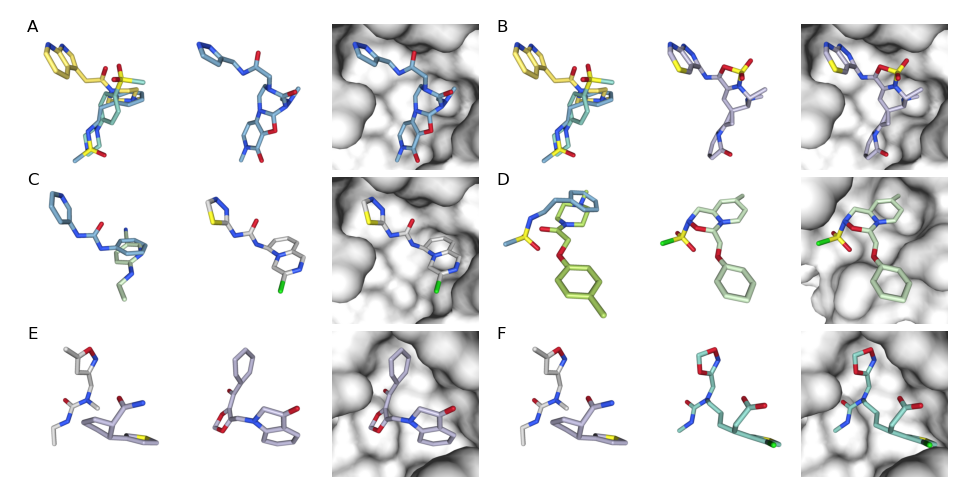

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 200

fig, axs = plt.subplots(n_rows, n_columns,
                        figsize=(n_columns, n_rows),
                        dpi=dpi,#was 200
                        #constrained_layout=True,
                        gridspec_kw=dict(hspace=0.05, wspace=0.05),
                        #subplot_kw=dict(box_aspect=1),
                        sharex=True, sharey=True
                       )

plt.xticks([], [])
plt.yticks([], [])

img_counter=0

for i,row in enumerate(axs):
      
    for j,ax in enumerate(row):
        
        selected_row = selected_df.iloc[img_counter//3]
        mol_id = selected_row["mol_id"]
        exp_id = selected_row["exp_id"]
        
        
        
        idx = img_counter//3
        
        if i == n_rows-1 and show_headings:#adding all titles stuff - should be done afterwards for clarity
            if j%3 == 0:
                ax.set_title(f'Reference', y=-0.3, loc='center', fontsize=6)
            if j%3 == 1:
                ax.set_title(f'Sample', y=-0.3, loc='center', fontsize=6)
            if j%3 == 2:
                ax.set_title(f'Bound', y=-0.3, loc='center', fontsize=6)
                
        if j%3 ==0:
            img = plt.imread(f"{path}{mol_id}_fragments.png")
            
            ax.annotate(f"{letters[idx]}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=6)
            
        elif j%3 == 1:
            img = plt.imread(f"{path}{mol_id}_sample.png")
        elif j%3 == 2:
            img = plt.imread(f"{path}{mol_id}_sample_bound.png")
        img_counter+=1
        

        ax.imshow(img)
        ax.axis('off')
        
#plt.savefig(f"figures/actual_final_figure_ref_sample_bound/ref_sample_bound_{dpi}_white_CD_swapped.png", pad_inches=None,facecolor='white', transparent=False)

plt.show()

In [ ]:
#3 fragments - 32 and 33
#messy fragments great results - 15

#t overlap - 13
#very nice results 26

#linker design
#dummy 10 and 18

# Show all graphs

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, axs = plt.subplots(n_rows, n_columns,
                        figsize=(n_columns, n_rows),
                        dpi=400,#was 200
                        #constrained_layout=True,
                        gridspec_kw=dict(hspace=0.05, wspace=0.05),
                        #subplot_kw=dict(box_aspect=1),
                        sharex=True, sharey=True
                       )

plt.xticks([], [])
plt.yticks([], [])

img_counter=0

for i,row in enumerate(axs):
      
    for j,ax in enumerate(row):
        
        selected_row = selected_df.iloc[img_counter//3]
        mol_id = selected_row["mol_id"]
        exp_id = selected_row["exp_id"]
        idx = img_counter//3
        
        if i == n_rows-1:#adding all titles stuff - should be done afterwards for clarity
            if j%3 == 0:
                ax.set_title(f'Reference', y=-0.3, loc='center', fontsize=8)
            if j%3 == 1:
                ax.set_title(f'Sample', y=-0.3, loc='center', fontsize=8)
            if j%3 == 2:
                ax.set_title(f'Bound', y=-0.3, loc='center', fontsize=8)
                
        if j%3 ==0:
            img = plt.imread(f"{path}{mol_id}_fragments.png")
            
            ax.annotate(f"{exp_id[-2:]} idx={idx}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=4)
            
        elif j%3 == 1:
            img = plt.imread(f"{path}{mol_id}_sample.png")
        elif j%3 == 2:
            img = plt.imread(f"{path}{mol_id}_graph.png")
        img_counter+=1
        

        ax.imshow(img)
        ax.axis('off')
        

plt.show()